In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [2]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

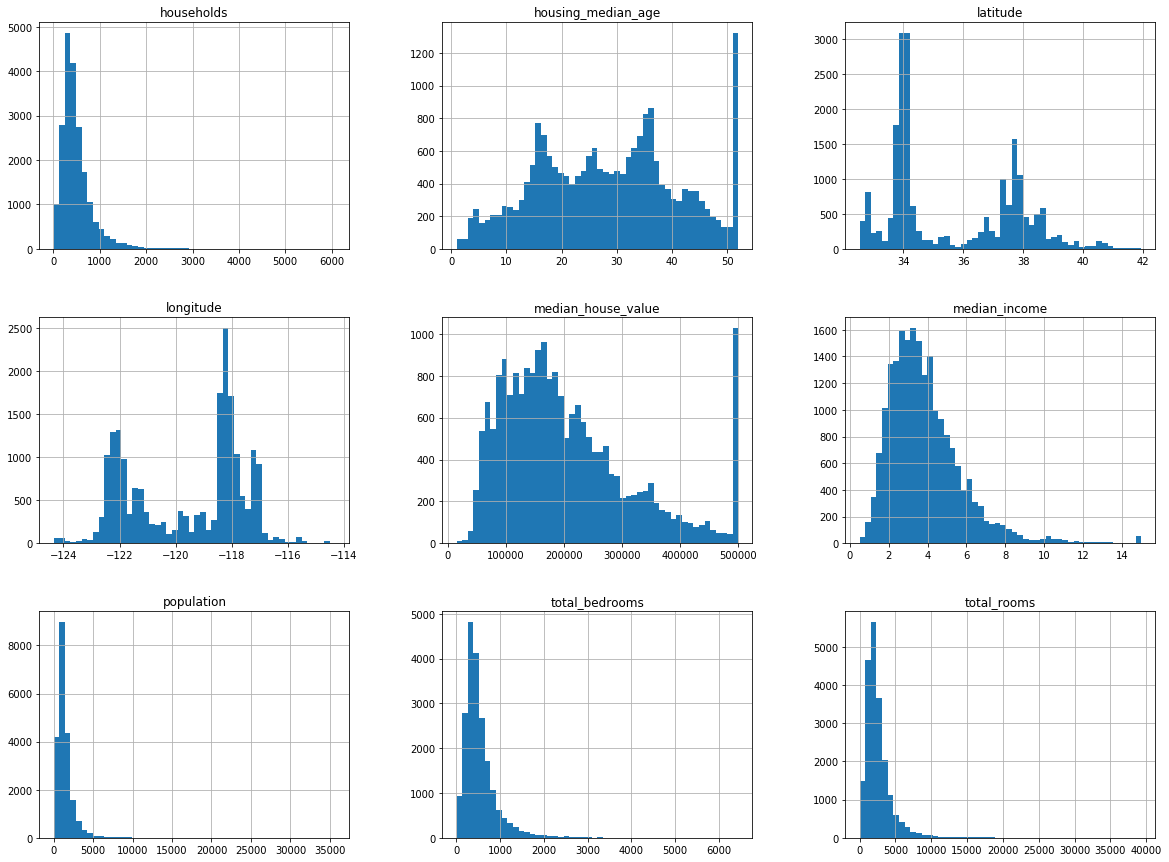

In [9]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [10]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[ : test_set_size]
    train_indices = shuffled_indices[test_set_size : ]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [12]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index()
#train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
housing_with_id["id"] = housing.longitude * 1000 + housing.latitude
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [14]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

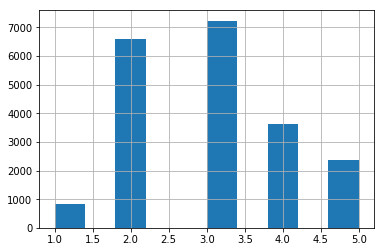

In [15]:
housing["income_cat"] = np.ceil(housing.median_income / 1.5)
housing["income_cat"].where(housing.income_cat < 5, 5.0, inplace=True)
housing["income_cat"].hist()
plt.show()

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set.income_cat.value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [17]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 地理データの可視化

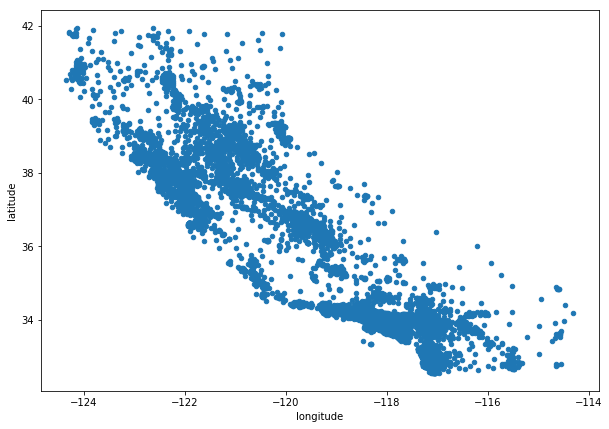

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10, 7))

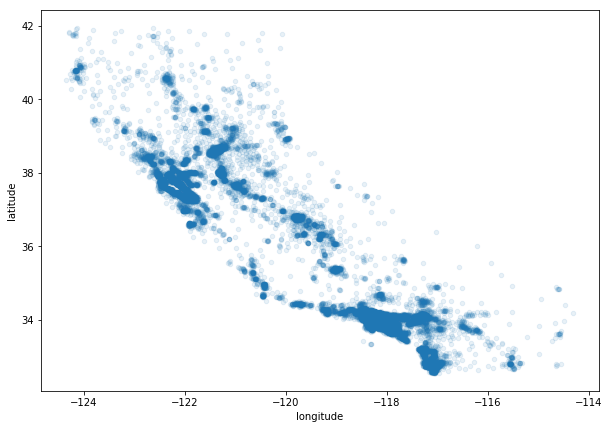

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(10, 7))

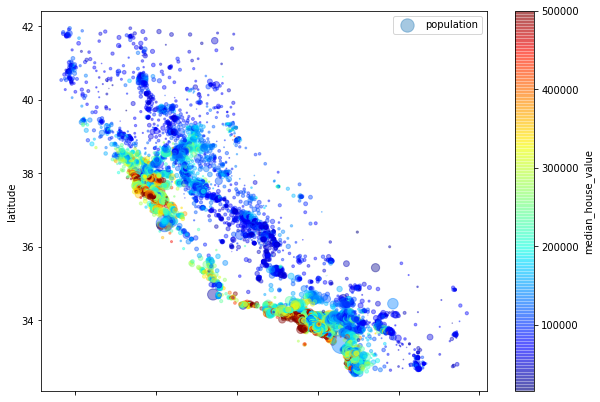

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             s=housing.population / 100, label="population", figsize=(10, 7), 
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

# 相関を探す

In [21]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967,-0.010690
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160,-0.085528
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623,-0.146920
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153,0.220528
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686,0.015662
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650,0.025809
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843,0.038490
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075,0.902750
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000,0.643892
income_cat,-0.010690,-0.085528,-0.146920,0.220528,0.015662,0.025809,0.038490,0.902750,0.643892,1.000000


In [22]:
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0aa00edf28>,
      dtype=object)

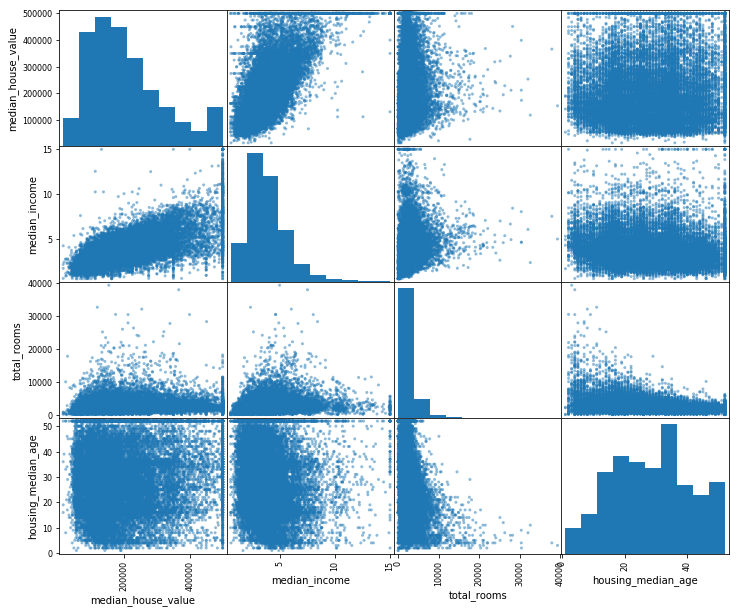

In [23]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 10))

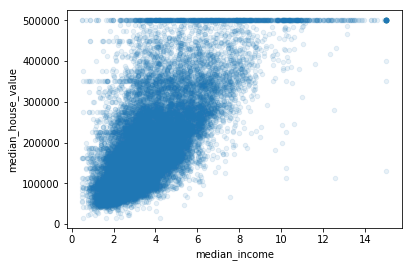

In [24]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

# 属性の組み合わせを試す

In [25]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967,-0.010690,-0.027540,0.092657,0.002476
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160,-0.085528,0.106389,-0.113815,0.002366
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623,-0.146920,-0.153277,0.136089,0.013191
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153,0.220528,0.133798,-0.187900,-0.024581
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686,0.015662,0.001538,0.084238,-0.028355
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650,0.025809,-0.072213,0.035319,0.069863
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843,0.038490,-0.080598,0.065087,-0.027309
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075,0.902750,0.326895,-0.615661,0.018766
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000,0.643892,0.151948,-0.255880,-0.023737
income_cat,-0.010690,-0.085528,-0.146920,0.220528,0.015662,0.025809,0.038490,0.902750,0.643892,1.000000,0.313054,-0.628541,0.009608


In [26]:
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

# 機械学習アルゴリズムに渡せるようにデータを準備する

In [27]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## データをクリーニングする

In [28]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

In [29]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [30]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [31]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [32]:
X = imputer.transform(housing_num)
print(X)

[[-121.89     37.29     38.     ...  710.      339.        2.7042]
 [-121.93     37.05     14.     ...  306.      113.        6.4214]
 [-117.2      32.77     31.     ...  936.      462.        2.8621]
 ...
 [-116.4      34.09      9.     ... 2098.      765.        3.2723]
 [-118.01     33.82     31.     ... 1356.      356.        4.0625]
 [-122.45     37.77     52.     ... 1269.      639.        3.575 ]]


In [33]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
5,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395
6,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839
7,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000
8,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242
9,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999


## テキスト／カテゴリ属性の処理

In [34]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [35]:
from future_encoders import OrdinalEncoder

In [36]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [37]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [38]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

## カスタム変換

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        rooms_per_household = X[:, household_ix] / X[:, population_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
            
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 0.47746478873239434,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 0.369281045751634,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 0.4935897435897436,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 0.3646329837940896,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 0.26253687315634217,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 0.5035460992907801,
        1.9859154929577465]], dtype=object)

## 変換パイプライン

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", Imputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ...,  1.21305708,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.05429335,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  1.38577261,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.00450763,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ..., -1.08905104,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ...,  1.49241584,
        -0.09586294,  0.10180567]])

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [42]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ("ord_encoder", OrdinalEncoder()),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [43]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [44]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [45]:
housing_prepared.shape

(16512, 16)

# モデルを洗濯して訓練する

## 訓練セットを訓練、評価する

In [46]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [236073.33746783 323557.20802254 231729.37518353  43447.04816166
 188872.8177501 ]


In [48]:
print("Lables:", some_labels)

Lables: 17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64


In [49]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

66036.74203252686

In [50]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [51]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## 交差検証を使ったよりよい評価

In [52]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([68856.58602238, 68502.29579701, 69857.14489638, 70033.81315924,
       73106.83241511, 74237.77793907, 69373.40025301, 70775.96319289,
       74864.34786106, 71615.88885552])

In [53]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [68856.58602238 68502.29579701 69857.14489638 70033.81315924
 73106.83241511 74237.77793907 69373.40025301 70775.96319289
 74864.34786106 71615.88885552]
Mean: 71122.40503916534
Standard deviation: 2141.331971873744


In [54]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [64606.62985559 64324.36604337 67829.97511352 68324.28394576
 65585.34886363 68864.92226787 64533.3339688  64245.87768439
 70106.63723569 64396.74949881]
Mean: 66281.81244774302
Standard deviation: 2138.8969774554635


In [55]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [51629.8455081  50425.7350807  52911.4845795  54965.82400269
 52150.02288221 55429.67456271 51187.36898267 50797.11512463
 55820.85437807 53188.06538472]
Mean: 52850.59904859964
Standard deviation: 1868.4206251424619


# モデルを微調整する

## グリッドサーチ

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error")

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [57]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [58]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [59]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64251.32286648349 {'max_features': 2, 'n_estimators': 3}
55505.201708820954 {'max_features': 2, 'n_estimators': 10}
53305.44301239409 {'max_features': 2, 'n_estimators': 30}
60579.59451475113 {'max_features': 4, 'n_estimators': 3}
53303.5744765375 {'max_features': 4, 'n_estimators': 10}
51001.51157563213 {'max_features': 4, 'n_estimators': 30}
59584.78800440798 {'max_features': 6, 'n_estimators': 3}
52751.186464887134 {'max_features': 6, 'n_estimators': 10}
50898.372666429765 {'max_features': 6, 'n_estimators': 30}
59354.58307731246 {'max_features': 8, 'n_estimators': 3}
52755.3804119623 {'max_features': 8, 'n_estimators': 10}
50777.13233688975 {'max_features': 8, 'n_estimators': 30}
63278.89476806132 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54608.65829814494 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60218.90399825604 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53100.4068032053 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

## 最良のモデルと誤差の分析

In [60]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.04859270e-02, 6.39245138e-02, 4.35785968e-02, 1.77538975e-02,
       1.39826539e-02, 1.56419091e-02, 1.60434049e-02, 3.83710533e-01,
       7.10580990e-02, 5.76466278e-02, 7.30535997e-02, 1.02464097e-02,
       1.57627600e-01, 8.02261046e-05, 1.62463553e-03, 3.54136619e-03])

In [63]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categorical_features[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.38371053339471817, 'median_income'),
 (0.07305359973363794, 'bedrooms_per_room'),
 (0.07105809904671447, 'rooms_per_hhold'),
 (0.07048592702513143, 'longitude'),
 (0.06392451376880035, 'latitude'),
 (0.05764662776615266, 'pop_per_hhold'),
 (0.04357859675453647, 'housing_median_age'),
 (0.017753897452462777, 'total_rooms'),
 (0.016043404922913264, 'households'),
 (0.01564190914401562, 'population'),
 (0.013982653887300434, 'total_bedrooms'),
 (0.010246409735253993, 'a')]

## テストセットでシステムを評価する

In [69]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47984.38939866418